## Imports

In [36]:
!pip install protpy
!pip install biopython

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import explained_variance_score,max_error,mean_absolute_error,mean_squared_error,mean_squared_log_error,r2_score
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn import metrics
import matplotlib.pyplot as plt
import pickle
import protpy as protpy

## Trainer class

In [38]:
# Define hyperparameter distributions for RandomizedSearchCV
Lasso_params = {
    "alpha": [0.1, 0.5, 1, 5, 10, 50, 100],
    "fit_intercept": [True, False],
    "tol": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 10]
}

Ridge_params = {
    "alpha": [0.1, 0.5, 1, 5, 10, 50, 100],
    "fit_intercept": [True, False],
    "tol": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 10],
    "solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
}

DT_params = {
    "max_depth": [2, 3, 4, 5],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6],
    "max_features": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

RF_params = {
    "max_depth": [2, 3, 4, 5],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6],
    "max_features": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

EN_params = {
    "alpha": [0.1, 0.5, 1, 5, 10, 50, 100],
    "l1_ratio": [0, 0.2, 0.4, 0.6, 0.8, 1],
    "tol": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 10, 15],
    "fit_intercept": [False]
}

SVR_params = {
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "degree": [2, 3, 4],
    "tol": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 10],
    "gamma": ['scale', 'auto'],
    "coef0": [0, 2, 4]
}

def get_scoring_function(scoring):
    if scoring == 'explained_variance':
        return explained_variance_score
    elif scoring == 'max_error':
        return max_error
    elif scoring == 'neg_mean_absolute_error':
        return lambda y_true, y_pred: -mean_absolute_error(y_true, y_pred)
    elif scoring == 'neg_mean_squared_error':
        return lambda y_true, y_pred: -mean_squared_error(y_true, y_pred)
    elif scoring == 'neg_mean_squared_log_error':
        return lambda y_true, y_pred: -mean_squared_log_error(y_true, y_pred)
    elif scoring == 'r2':
        return r2_score
    else:
        raise ValueError(f"Scoring method '{scoring}' is not recognized. Available methods are: ['explained_variance', 'max_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'r2']")


class MLModelTrainer:
    def __init__(self, model_name, n_iter=10, cv=5, scoring='r2', warm_start=False, group_by_gene = True):
        self.model_name = model_name
        self.n_iter = n_iter
        self.cv = cv
        self.scoring = scoring
        self.group_by_gene=group_by_gene
        
        # Initialize model based on the specified model_name
        self.model, self.param_distributions = self._initialize_model(warm_start)
        
        
            

    def _initialize_model(self, warm_start):
        models = {
            'lasso': Lasso(warm_start=warm_start),
            'ridge': Ridge(),
            'decision_tree': DecisionTreeRegressor(),
            'random_forest': RandomForestRegressor(warm_start=warm_start),
            'elastic_net': ElasticNet(warm_start=warm_start),
            'svr': SVR()
        }
        
        params = {
            'lasso': Lasso_params,
            'ridge': Ridge_params,
            'decision_tree': DT_params,
            'random_forest': RF_params,
            'elastic_net': EN_params,
            'svr': SVR_params
        }
        
        if self.model_name not in models:
            raise ValueError(f"Model '{self.model_name}' is not supported.")
        
        return models[self.model_name], params[self.model_name]
    
    def fit(self, X, y):
        # Create a pipeline with standard scaling and the specified model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Standardize features
            ('model', self.model)
        ])

        if self.param_distributions:
            # Perform RandomizedSearchCV for hyperparameter tuning
            random_search = RandomizedSearchCV(
                pipeline['model'], 
                param_distributions=self.param_distributions,
                n_iter=self.n_iter, 
                cv=self.cv, 
                scoring=self.scoring,
                random_state=42, 
                n_jobs=-1
            )
            random_search.fit(X, y)
            self.best_model = random_search.best_estimator_
            self.best_params = random_search.best_params_
        else:
            # Fit the pipeline without hyperparameter tuning
            self.best_model = pipeline.fit(X, y)
            self.best_params = None

        
    def cross_validation(self, X, y, input_value=None):
        self.X = X.copy()
        self.y = y.copy()

        NUM_TRIALS = input_value if input_value else self.n_iter

        '''if 'Group' in X.columns:
            X.drop(columns=['Group'], inplace=True)

        # Create the group column for grouping
        X['Group'] = X.groupby(list(set(X.columns) - set(['Transcripts']))).ngroup()'''

        if(self.group_by_gene):
            self.G=self.X['Gene']
            
        else:
            self.G=self.X.index
            
        self.X.drop("Gene", inplace=True, axis=1)
        
        self.features = self.X.columns
        self.itr_number = []
        self.outer_results = []
        self.inner_results = []
        self.model_params = []
        self.G_test_list = []
        self.y_test_list = []
        self.pred_list = []

        for i in range(NUM_TRIALS):
            cv_outer = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=i)

            for train_index, test_index in cv_outer.split(self.X, self.y, self.G):
                X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
                y_train, y_test = self.y[train_index], self.y[test_index]
                G_train, G_test = self.G[train_index], self.G[test_index]

                model_to_use = self.best_model if hasattr(self, 'best_model') else self.model

                G_test = np.array(G_test)
                self.G_test_list.append(G_test)
                y_test = np.array(y_test)
                self.y_test_list.append(y_test)

                cv_inner = GroupKFold(n_splits=10)
                search = RandomizedSearchCV(
                    estimator=model_to_use,
                    param_distributions=self.param_distributions,
                    n_iter=100,
                    verbose=0,
                    scoring=self.scoring,
                    cv=cv_inner,
                    n_jobs=6,
                    refit=True
                )

                result = search.fit(X_train, y_train, groups=G_train)
                best_model = result.best_estimator_
                best_score = abs(result.best_score_)
                self.inner_results.append(best_score)

                yhat = best_model.predict(X_test)
                self.pred_list.append(yhat)

                scoring_func = get_scoring_function(self.scoring)
                acc = scoring_func(y_test, yhat)

                self.itr_number.append(i + 1)
                self.outer_results.append(acc)
                self.model_params.append(result.best_params_)

                print('\n################################################################\n\nSTATUS REPORT:')
                print(f'Iteration {i + 1} of {NUM_TRIALS} runs completed')
                print(f'Test_Score: {acc:.3f}, Best_Valid_Score: {best_score:.3f}\n\nBest_Model_Params:\n{result.best_params_}')
                print("\n################################################################\n ")

                plt.figure(figsize=(10, 6))
                plt.scatter(y_test, yhat, c=X_test["Transcripts"], cmap='cool', edgecolor='k', alpha=0.3, edgecolors='face')
                plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
                plt.xlabel('True Values')
                plt.ylabel('Predictions')
                plt.title('Prediction vs True Values')
                plt.colorbar(label="Number of transcripts")
                plt.grid(True)
                plt.show()

          
    def find_best_model(self):
        # assign the best model paramaters
        best_model_params = self.CV_dataset.iloc[0,3]
        # set params from the best model to a class object
        best_model = self.model.set_params(**best_model_params)
        self.best_model = best_model.fit(self.X, self.y)
        self.y_pred=self.best_model.predict(self.X)
    
    def results(self):   
        #create dataframe with results of nested CV
        list_of_tuples = list(zip(self.itr_number, self.inner_results, self.outer_results, self.model_params, self.G_test_list, self.y_test_list, self.pred_list))
        CV_dataset = pd.DataFrame(list_of_tuples, columns = ['Iter', 'Valid Score', 'Test Score', 'Model Parms', 'Genes', 'True Abundance', 'Predicted Abundance'])
        CV_dataset['Score_difference'] = abs(CV_dataset['Valid Score'] - CV_dataset['Test Score']) #Groupby dataframe model iterations that best fit the data (i.e., validitaion <= test)
        CV_dataset.sort_values(by=['Score_difference', 'Test Score'], ascending=[True, False], inplace=True) 
        CV_dataset = CV_dataset.reset_index(drop=True) # Reset index of dataframe
        # save the results as a class object
        self.CV_dataset = CV_dataset
    
    def get_importances(self):
        if(self.model_name=='decision_tree' or self.model_name=='random_forest'):
            imp=pd.DataFrame([self.features,self.best_model.feature_importances_])
        elif(self.model_name=='lasso' or self.model_name=='ridge' or self.model_name=='elastic_net'):
            imp=pd.DataFrame([self.features,self.best_model.coef_])
        imp=imp.T
        imp.columns=["Feature", "Importance"]
        imp.sort_values(by="Importance", ascending=False, inplace=True)
        return imp.loc[imp["Importance"]>0].copy()
    
    def plot_predictions_vs_true(self, log=False):
        if not hasattr(self, 'y_test') or not hasattr(self, 'y_pred'):
            raise ValueError("Model must be fitted before plotting.")
        
        plt.figure(figsize=(10, 6))
        plt.scatter(self.y_test, self.y_pred, c=self.X_test["Transcripts"], cmap='cool', edgecolor='k', alpha=0.3, edgecolors='face')
        plt.plot([min(self.y_test), max(self.y_test)], [min(self.y_test), max(self.y_test)], color='red', linestyle='--')
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        plt.title('Prediction vs True Values')
        if(log==True):
            plt.xscale('log')
            plt.yscale('log')
        plt.colorbar()
        plt.grid(True)
        plt.show()
        
# Example usage:




## Choose descriptors

In [39]:
from Bio import SeqIO
def get_fasta(geneList):
    gene_to_seq = {}
    sequences=[]
    geneList=list(geneList)
    successfulGenes=[]

    for record in SeqIO.parse("/kaggle/input/uniprot-swissprot-fasta/uniprot_sprot.fasta", "fasta"):
        org=record.name.split("|")[2].split("_")[1]
        try:
            gene=record.description.split("GN=")[1].split(" ")[0]
        except:
            gene=record.name.split("|")[2].split("_")[0]
        if(org == "HUMAN" and gene in geneList):
            gene_to_seq[gene]=record.seq
            #print(gene_to_seq)
    for gene in geneList:
        try:
            new_seq=gene_to_seq[gene]
            sequences.append(new_seq)
            successfulGenes.append(gene)
        except:
            pass
    return sequences, successfulGenes

In [40]:
quant_func="median" # median or mean

X_raw=pd.read_excel("/kaggle/input/log-transformed-prot-vs-rna/Inter-cluster_points_log_imputated.xlsx")
y_raw=X_raw["y_"+quant_func]
y_raw.columns=["Proteins"]
X_raw=X_raw[["Gene", "x_"+quant_func]]
X_raw.columns=["Gene", "Transcripts"]
display(X_raw)

,Gene,Transcripts
0,CLEC12A,0.334289
1,CLEC12A,0.009150
2,CLEC12A,0.050267
3,CLEC12A,0.014250
4,CLEC12A,0.009068
...,...,...
10093,ICAM1,0.043033
10094,ICAM1,0.005941
10095,ICAM1,0.226442
10096,ICAM1,0.351083


In [41]:
descriptors='DPComp' # AAComp, DPComp, CTriad, MBAuto

sequences, successfulGenes=get_fasta(X_raw["Gene"])
to_keep=X_raw['Gene'].isin(successfulGenes)
X = X_raw[to_keep]
y = y_raw[to_keep]
X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)

descList=[]
if(descriptors=='AAComp'):
    for seq in sequences:
        descList.append(protpy.amino_acid_composition(str(seq)))
    desc_df=pd.DataFrame(np.squeeze(descList))
elif(descriptors=='CTriad'):
    for seq in sequences:
        descList.append(protpy.conjoint_triad(str(seq)))
    desc_df=pd.DataFrame(np.squeeze(descList))
elif(descriptors=='DPComp'):
    for seq in sequences:
        descList.append(protpy.dipeptide_composition(str(seq)))
    desc_df=pd.DataFrame(np.squeeze(descList))
elif(descriptors=='MBAuto'):
    for seq in sequences:
        descList.append(protpy.moreaubroto_autocorrelation(str(seq)))
    desc_df=pd.DataFrame(np.squeeze(descList))

#desc_df.reset_index(inplace=True, drop=True)

X=pd.concat([X, desc_df], axis=1)
X.columns = X.columns.astype(str)

display(X)

,Gene,Transcripts,0,1,2,3,4,5,6,7,...,390,391,392,393,394,395,396,397,398,399
0,CLEC12A,0.334289,0.76,0.38,0.38,0.00,0.0,0.00,0.00,0.0,...,0.0,0.00,0.0,0.00,0.00,0.38,0.0,0.38,0.38,0.38
1,CLEC12A,0.009150,0.76,0.38,0.38,0.00,0.0,0.00,0.00,0.0,...,0.0,0.00,0.0,0.00,0.00,0.38,0.0,0.38,0.38,0.38
2,CLEC12A,0.050267,0.76,0.38,0.38,0.00,0.0,0.00,0.00,0.0,...,0.0,0.00,0.0,0.00,0.00,0.38,0.0,0.38,0.38,0.38
3,CLEC12A,0.014250,0.76,0.38,0.38,0.00,0.0,0.00,0.00,0.0,...,0.0,0.00,0.0,0.00,0.00,0.38,0.0,0.38,0.38,0.38
4,CLEC12A,0.009068,0.76,0.38,0.38,0.00,0.0,0.00,0.00,0.0,...,0.0,0.00,0.0,0.00,0.00,0.38,0.0,0.38,0.38,0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10027,ICAM1,0.043033,0.19,0.00,0.00,0.38,0.0,0.38,0.19,0.0,...,0.0,0.19,0.0,0.19,0.19,0.38,0.0,0.00,0.19,0.00
10028,ICAM1,0.005941,0.19,0.00,0.00,0.38,0.0,0.38,0.19,0.0,...,0.0,0.19,0.0,0.19,0.19,0.38,0.0,0.00,0.19,0.00
10029,ICAM1,0.226442,0.19,0.00,0.00,0.38,0.0,0.38,0.19,0.0,...,0.0,0.19,0.0,0.19,0.19,0.38,0.0,0.00,0.19,0.00
10030,ICAM1,0.351083,0.19,0.00,0.00,0.38,0.0,0.38,0.19,0.0,...,0.0,0.19,0.0,0.19,0.19,0.38,0.0,0.00,0.19,0.00


## Remove genes with low variance

In [42]:
var_threshold=0.5

high_var_genes=[]

for g in X["Gene"]:
    if((X.loc[X["Gene"]==g,"Transcripts"]>var_threshold).any()):
        high_var_genes.append(g)
        
high_var_genes=list(set(high_var_genes))
print(len(high_var_genes))

high_var_index=(X["Gene"].isin(high_var_genes))
X=X.loc[high_var_index]
y=y.loc[high_var_index]
X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)

65


## Multiply all descriptors by the number of transcripts (per row)

In [43]:
'''import pandas as pd

# Copy the relevant columns
X_mul = X[['Gene', 'Transcripts']].copy()

# Multiply each descriptor column by the "Transcripts" column
X_mul[X.columns[2:]] = X[X.columns[2:]].mul(X['Transcripts'], axis=0)

X = X_mul
display(X)'''


'import pandas as pd\n\n# Copy the relevant columns\nX_mul = X[[\'Gene\', \'Transcripts\']].copy()\n\n# Multiply each descriptor column by the "Transcripts" column\nX_mul[X.columns[2:]] = X[X.columns[2:]].mul(X[\'Transcripts\'], axis=0)\n\nX = X_mul\ndisplay(X)'

In [44]:
import pandas as pd

# Copy the relevant columns
X_intercepts = X[X.columns[2:]].copy()
X_mul = X[['Gene', 'Transcripts']].copy()

# Multiply each descriptor column by the "Transcripts" column
X_mul[X.columns[2:]] = X[X.columns[2:]].mul(X['Transcripts'], axis=0)
X=X_mul.join(X_intercepts, rsuffix='_int')

display(X)


/tmp/ipykernel_212/3626142155.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_mul[X.columns[2:]] = X[X.columns[2:]].mul(X['Transcripts'], axis=0)
/tmp/ipykernel_212/3626142155.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_mul[X.columns[2:]] = X[X.columns[2:]].mul(X['Transcripts'], axis=0)
/tmp/ipykernel_212/3626142155.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

,Gene,Transcripts,0,1,2,3,4,5,6,7,...,390_int,391_int,392_int,393_int,394_int,395_int,396_int,397_int,398_int,399_int
0,CLEC12A,0.334289,0.254059,0.127030,0.127030,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.38,0.00,0.38,0.38,0.38
1,CLEC12A,0.009150,0.006954,0.003477,0.003477,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.38,0.00,0.38,0.38,0.38
2,CLEC12A,0.050267,0.038203,0.019102,0.019102,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.38,0.00,0.38,0.38,0.38
3,CLEC12A,0.014250,0.010830,0.005415,0.005415,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.38,0.00,0.38,0.38,0.38
4,CLEC12A,0.009068,0.006892,0.003446,0.003446,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.38,0.00,0.38,0.38,0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4285,IL3RA,0.000651,0.000176,0.000000,0.000345,0.000176,0.000176,0.000520,0.0,0.000176,...,0.0,0.0,0.0,0.0,0.0,0.27,0.53,0.00,0.00,0.00
4286,IL3RA,0.001813,0.000489,0.000000,0.000961,0.000489,0.000489,0.001450,0.0,0.000489,...,0.0,0.0,0.0,0.0,0.0,0.27,0.53,0.00,0.00,0.00
4287,IL3RA,0.000365,0.000099,0.000000,0.000194,0.000099,0.000099,0.000292,0.0,0.000099,...,0.0,0.0,0.0,0.0,0.0,0.27,0.53,0.00,0.00,0.00
4288,IL3RA,0.771555,0.208320,0.000000,0.408924,0.208320,0.208320,0.617244,0.0,0.208320,...,0.0,0.0,0.0,0.0,0.0,0.27,0.53,0.00,0.00,0.00


## Grouped

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.551e+03, tolerance: 1.120e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.601e+03, tolerance: 1.171e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


################################################################

STATUS REPORT:
Iteration 1 of 5 runs completed
Test_Score: -0.049, Best_Valid_Score: 0.098

Best_Model_Params:
{'tol': 1e-06, 'l1_ratio': 0, 'fit_intercept': False, 'alpha': 5}

################################################################
 


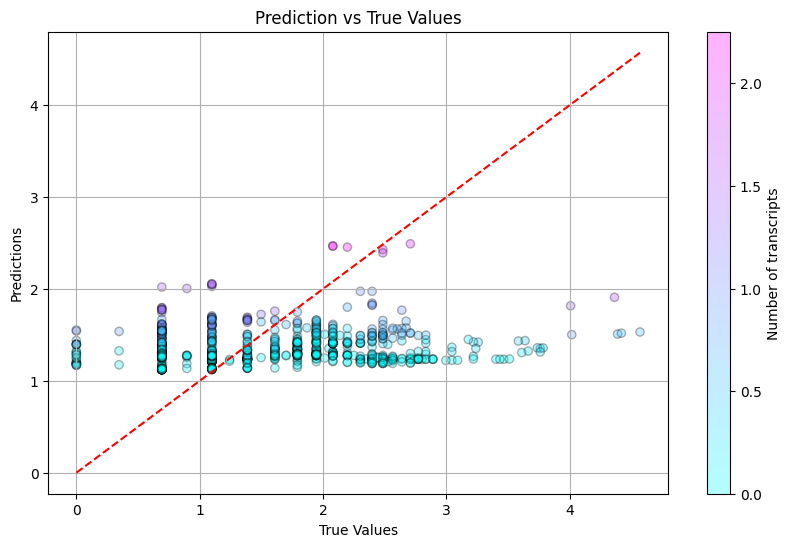

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.081e+03, tolerance: 1.138e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.409e+02, tolerance: 1.158e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


################################################################

STATUS REPORT:
Iteration 2 of 5 runs completed
Test_Score: -0.123, Best_Valid_Score: 0.175

Best_Model_Params:
{'tol': 0.01, 'l1_ratio': 0, 'fit_intercept': False, 'alpha': 1}

################################################################
 


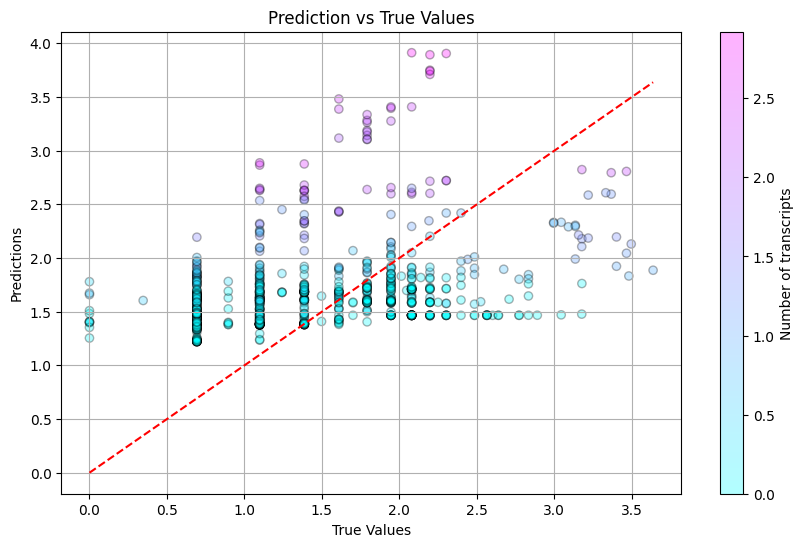

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.133e+02, tolerance: 1.073e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.346e+02, tolerance: 1.115e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


################################################################

STATUS REPORT:
Iteration 3 of 5 runs completed
Test_Score: -0.041, Best_Valid_Score: 0.144

Best_Model_Params:
{'tol': 0.0001, 'l1_ratio': 0, 'fit_intercept': False, 'alpha': 5}

################################################################
 


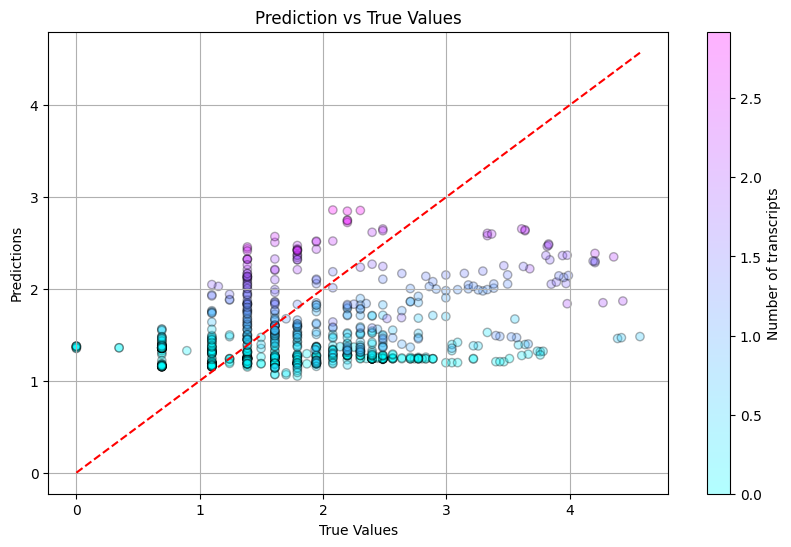

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.421e+03, tolerance: 1.002e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.438e+03, tolerance: 1.025e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


################################################################

STATUS REPORT:
Iteration 4 of 5 runs completed
Test_Score: 0.042, Best_Valid_Score: 0.067

Best_Model_Params:
{'tol': 0.001, 'l1_ratio': 0, 'fit_intercept': False, 'alpha': 1}

################################################################
 


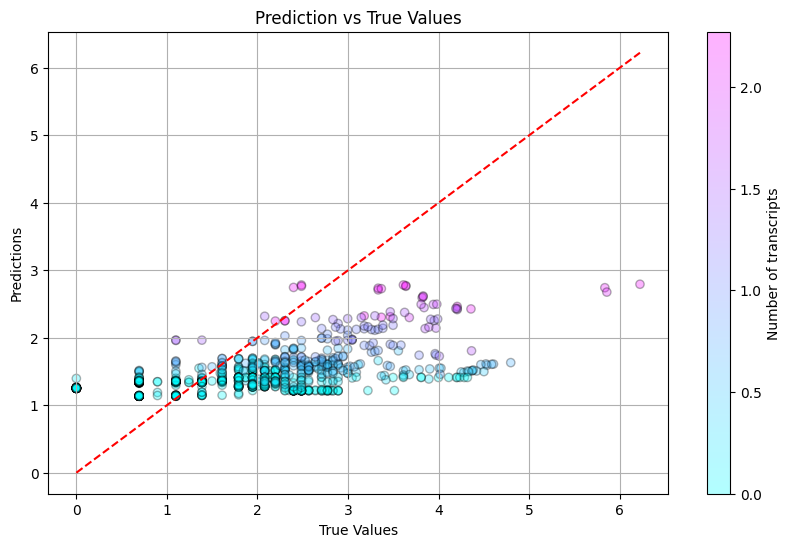

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.068e+03, tolerance: 1.090e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.305e+03, tolerance: 1.157e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


################################################################

STATUS REPORT:
Iteration 5 of 5 runs completed
Test_Score: 0.070, Best_Valid_Score: 0.048

Best_Model_Params:
{'tol': 0.0001, 'l1_ratio': 0, 'fit_intercept': False, 'alpha': 5}

################################################################
 


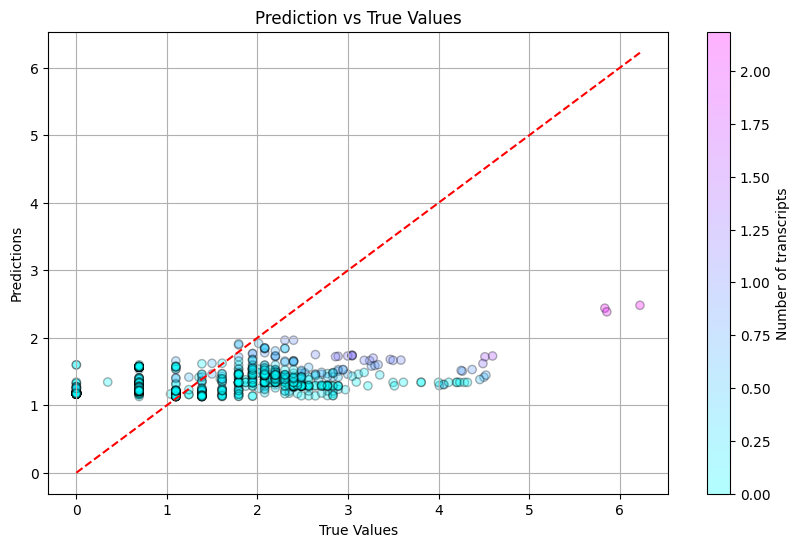

   Iter  Valid Score  Test Score  \
0     5     0.047508    0.069838   
1     4     0.067036    0.041773   
2     1     0.097628   -0.048907   
3     3     0.144129   -0.041056   
4     2     0.174867   -0.123127   

                                         Model Parms  \
0  {'tol': 0.0001, 'l1_ratio': 0, 'fit_intercept'...   
1  {'tol': 0.001, 'l1_ratio': 0, 'fit_intercept':...   
2  {'tol': 1e-06, 'l1_ratio': 0, 'fit_intercept':...   
3  {'tol': 0.0001, 'l1_ratio': 0, 'fit_intercept'...   
4  {'tol': 0.01, 'l1_ratio': 0, 'fit_intercept': ...   

                                               Genes  \
0  [CLEC12A, CLEC12A, CLEC12A, CLEC12A, CLEC12A, ...   
1  [KLRD1, KLRD1, KLRD1, KLRD1, KLRD1, KLRD1, KLR...   
2  [FCRL5, FCRL5, FCRL5, FCRL5, FCRL5, FCRL5, FCR...   
3  [FCGR3A, FCGR3A, FCGR3A, FCGR3A, FCGR3A, FCGR3...   
4  [CD8A, CD8A, CD8A, CD8A, CD8A, CD8A, CD8A, CD8...   

                                      True Abundance  \
0  [4.060442924499512, 1.098612308502197, 1.60943... 

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.164e+03, tolerance: 1.538e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


,Feature,Importance
590,189_int,0.052552
716,315_int,0.04068
586,185_int,0.037647
501,100_int,0.035723
516,115_int,0.031556
...,...,...
362,361,0.000124
775,374_int,0.000121
157,156,0.000103
140,139,0.00007


,Model,Iter,Valid Score,Test Score,Model Parms,Genes,True Abundance,Predicted Abundance,Score_difference,Highest Transcript Importance
0,elastic_net,5,0.047508,0.069838,"{'tol': 0.0001, 'l1_ratio': 0, 'fit_intercept'...","[CLEC12A, CLEC12A, CLEC12A, CLEC12A, CLEC12A, ...","[4.060442924499512, 1.098612308502197, 1.60943...","[1.30523834550371, 1.1582062000128868, 1.17679...",0.022330,0.014108
1,elastic_net,4,0.067036,0.041773,"{'tol': 0.001, 'l1_ratio': 0, 'fit_intercept':...","[KLRD1, KLRD1, KLRD1, KLRD1, KLRD1, KLRD1, KLR...","[0.6931471824645996, 0.6931471824645996, 0.693...","[1.3372148953384362, 1.3378278964501433, 1.489...",0.025263,0.014108
2,elastic_net,1,0.097628,-0.048907,"{'tol': 1e-06, 'l1_ratio': 0, 'fit_intercept':...","[FCRL5, FCRL5, FCRL5, FCRL5, FCRL5, FCRL5, FCR...","[0.6931471824645996, 0.6931471824645996, 0.693...","[1.306941909759123, 1.3957359883650005, 1.3209...",0.146535,0.014108
3,elastic_net,3,0.144129,-0.041056,"{'tol': 0.0001, 'l1_ratio': 0, 'fit_intercept'...","[FCGR3A, FCGR3A, FCGR3A, FCGR3A, FCGR3A, FCGR3...","[1.609437942504883, 1.386294364929199, 1.79175...","[1.2641908445991186, 1.2436144846318098, 1.470...",0.185186,0.014108
4,elastic_net,2,0.174867,-0.123127,"{'tol': 0.01, 'l1_ratio': 0, 'fit_intercept': ...","[CD8A, CD8A, CD8A, CD8A, CD8A, CD8A, CD8A, CD8...","[0.6931471824645996, 0.6931471824645996, 0.693...","[1.2285451577464825, 1.231574725364203, 1.3072...",0.297995,0.014108


In [45]:
#model_names=['decision_tree', 'random_forest', 'elastic_net']
model_names=['elastic_net']

best_models=[]
CV_datasets=[]
model_transcript_imp=[]
for model_name in model_names:
    trainer = MLModelTrainer(model_name=model_name, n_iter=5, cv=5, group_by_gene=True)
    trainer.cross_validation(X,y)
    trainer.results()
    trainer.find_best_model()
    print(trainer.CV_dataset)
    print(trainer.best_model)
    best_models.append(trainer.best_model)
    importances=trainer.get_importances()
    display(importances)
    if("Transcripts" in importances["Feature"].values):
        model_transcript_imp.append(importances.loc[importances["Feature"]=="Transcripts", "Importance"].values[0])
    else:
        model_transcript_imp.append(0)
    CV_datasets.append(trainer.CV_dataset)
    trainer.CV_dataset.to_pickle("intercluster_"+descriptors+"_grouped_"+model_name+".pkl", compression='infer', protocol=5, storage_options=None) # save dataframe as pickle file
    with open('/kaggle/working/intercluster_'+descriptors+'_grouped_'+model_name+'_model.pkl', 'wb') as file: # Save the Model to pickle file
              pickle.dump(trainer.best_model, file)
combined_datasets=pd.concat(CV_datasets, axis=0)
model_col=[]
transcript_imp_col=[]
for j, m in enumerate(model_names):
    for i in range(5):
        model_col.append(m)
        transcript_imp_col.append(model_transcript_imp[j])
combined_datasets.insert(0,"Model",model_col)
combined_datasets["Highest Transcript Importance"]=transcript_imp_col
combined_datasets.sort_values(by=['Score_difference', 'Test Score'], ascending=[True, False], inplace=True)
display(combined_datasets)
combined_datasets.to_excel("intercluster_"+descriptors+"_T-mul_highvar_protIntercept_"+quant_func+"_grouped.xlsx")

In [46]:
'''#best_models[0].predict
temp_df=pd.concat([X, y], axis=1).sort_values(by="Transcripts", ascending=True)
display(temp_df)
temp_df=temp_df.loc[X["Gene"]=="KLRD1"].copy()
y_true=temp_df["y_"+quant_func]
temp_df.drop(["Gene", "y_"+quant_func], inplace=True, axis=1)
y_pred=best_models[2].predict(temp_df)

plt.scatter(temp_df["Transcripts"], y_true)
plt.plot(temp_df["Transcripts"], y_pred, 'r')
plt.show()'''

'#best_models[0].predict\ntemp_df=pd.concat([X, y], axis=1).sort_values(by="Transcripts", ascending=True)\ndisplay(temp_df)\ntemp_df=temp_df.loc[X["Gene"]=="KLRD1"].copy()\ny_true=temp_df["y_"+quant_func]\ntemp_df.drop(["Gene", "y_"+quant_func], inplace=True, axis=1)\ny_pred=best_models[2].predict(temp_df)\n\nplt.scatter(temp_df["Transcripts"], y_true)\nplt.plot(temp_df["Transcripts"], y_pred, \'r\')\nplt.show()'

## Non-Grouped

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.524e+03, tolerance: 1.093e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e+03, tolerance: 1.103e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


################################################################

STATUS REPORT:
Iteration 1 of 5 runs completed
Test_Score: 0.736, Best_Valid_Score: 0.713

Best_Model_Params:
{'tol': 0.1, 'l1_ratio': 0, 'fit_intercept': False, 'alpha': 0.1}

################################################################
 


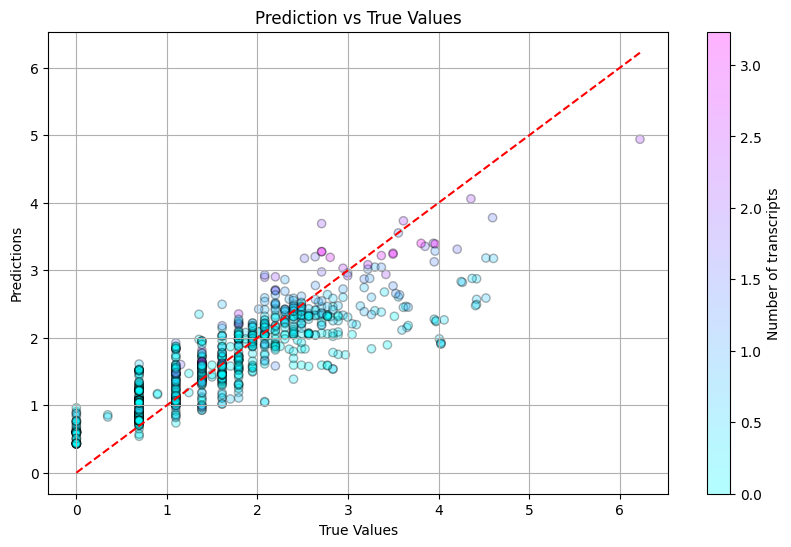

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.251e+03, tolerance: 1.118e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.249e+03, tolerance: 1.117e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


################################################################

STATUS REPORT:
Iteration 2 of 5 runs completed
Test_Score: 0.543, Best_Valid_Score: 0.526

Best_Model_Params:
{'tol': 0.0001, 'l1_ratio': 0, 'fit_intercept': False, 'alpha': 0.5}

################################################################
 


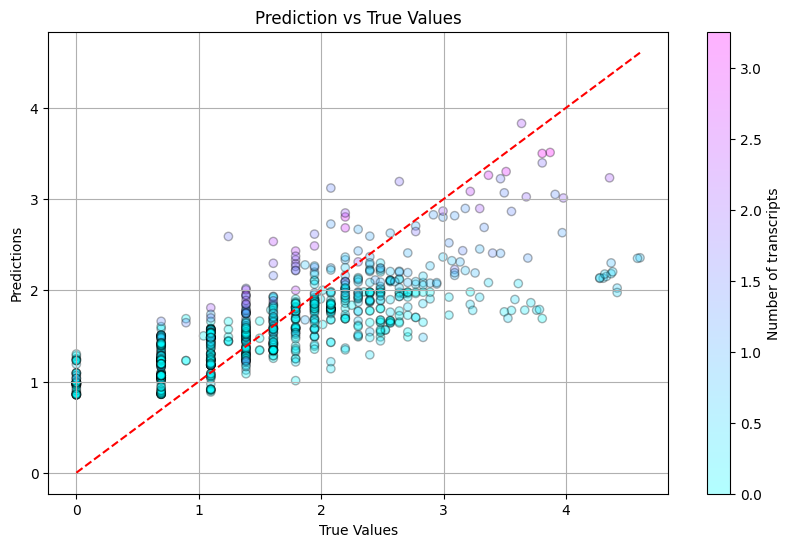

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.491e+03, tolerance: 1.106e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.473e+03, tolerance: 1.102e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


################################################################

STATUS REPORT:
Iteration 3 of 5 runs completed
Test_Score: 0.724, Best_Valid_Score: 0.720

Best_Model_Params:
{'tol': 0.001, 'l1_ratio': 0, 'fit_intercept': False, 'alpha': 0.1}

################################################################
 


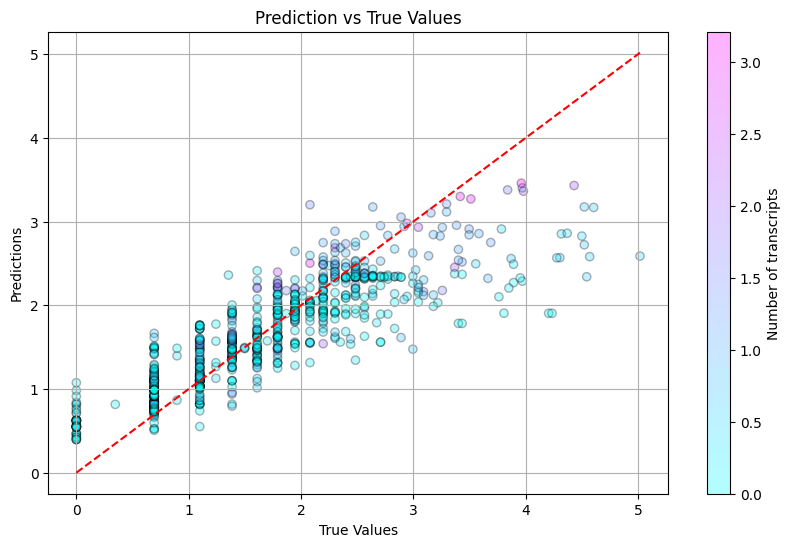

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.200e+03, tolerance: 1.108e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.178e+03, tolerance: 1.104e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


################################################################

STATUS REPORT:
Iteration 4 of 5 runs completed
Test_Score: 0.697, Best_Valid_Score: 0.725

Best_Model_Params:
{'tol': 0.0001, 'l1_ratio': 0, 'fit_intercept': False, 'alpha': 0.1}

################################################################
 


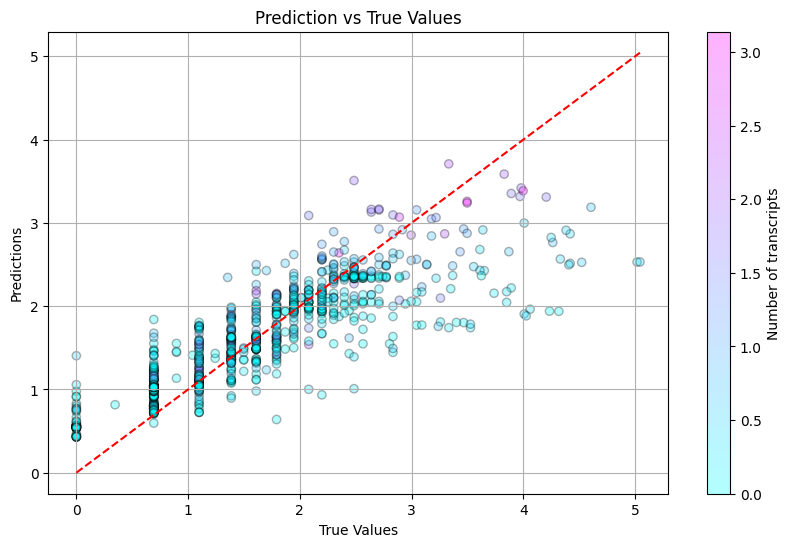

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.522e+02, tolerance: 1.114e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.518e+02, tolerance: 1.113e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


################################################################

STATUS REPORT:
Iteration 5 of 5 runs completed
Test_Score: 0.714, Best_Valid_Score: 0.726

Best_Model_Params:
{'tol': 0.01, 'l1_ratio': 0, 'fit_intercept': False, 'alpha': 0.1}

################################################################
 


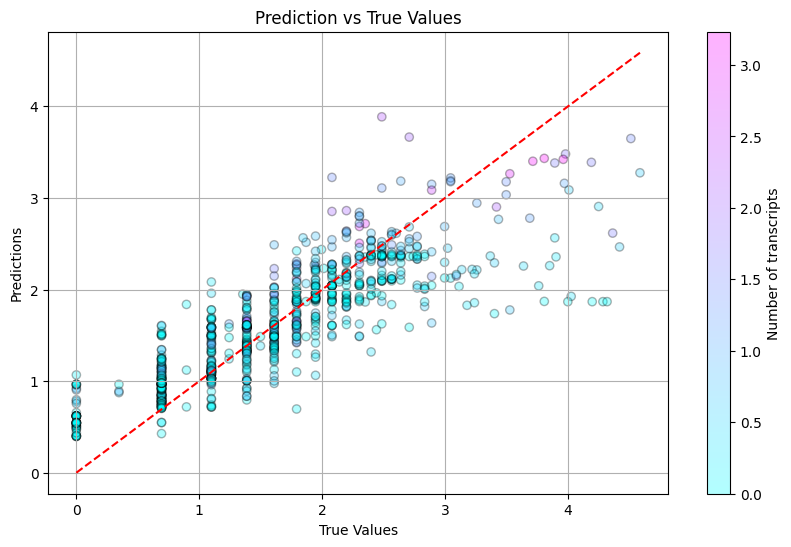

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.216e+02, tolerance: 1.538e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


   Iter  Valid Score  Test Score  \
0     3     0.719779    0.723752   
1     5     0.726216    0.713659   
2     2     0.526475    0.543316   
3     1     0.712911    0.735589   
4     4     0.725166    0.697499   

                                         Model Parms  \
0  {'tol': 0.001, 'l1_ratio': 0, 'fit_intercept':...   
1  {'tol': 0.01, 'l1_ratio': 0, 'fit_intercept': ...   
2  {'tol': 0.0001, 'l1_ratio': 0, 'fit_intercept'...   
3  {'tol': 0.1, 'l1_ratio': 0, 'fit_intercept': F...   
4  {'tol': 0.0001, 'l1_ratio': 0, 'fit_intercept'...   

                                               Genes  \
0  [3, 4, 15, 18, 20, 27, 30, 45, 57, 61, 62, 64,...   
1  [13, 15, 20, 26, 29, 36, 44, 49, 67, 68, 72, 7...   
2  [1, 3, 6, 7, 12, 13, 17, 19, 21, 37, 40, 44, 4...   
3  [1, 17, 22, 23, 30, 31, 33, 34, 36, 39, 42, 45...   
4  [0, 6, 20, 21, 22, 25, 30, 31, 33, 34, 37, 38,...   

                                      True Abundance  \
0  [1.098612308502197, 1.098612308502197, 1.09861... 

,Feature,Importance
598,197_int,0.13498
586,185_int,0.134143
650,249_int,0.132752
350,349,0.132474
501,100_int,0.121222
...,...,...
391,390,0.000636
376,375,0.000408
384,383,0.000298
361,360,0.000184


,Model,Iter,Valid Score,Test Score,Model Parms,Genes,True Abundance,Predicted Abundance,Score_difference,Highest Transcript Importance
0,elastic_net,3,0.719779,0.723752,"{'tol': 0.001, 'l1_ratio': 0, 'fit_intercept':...","[3, 4, 15, 18, 20, 27, 30, 45, 57, 61, 62, 64,...","[1.098612308502197, 1.098612308502197, 1.09861...","[1.4851851299125705, 1.4750132132094746, 1.505...",0.003973,0.034006
1,elastic_net,5,0.726216,0.713659,"{'tol': 0.01, 'l1_ratio': 0, 'fit_intercept': ...","[13, 15, 20, 26, 29, 36, 44, 49, 67, 68, 72, 7...","[1.098612308502197, 1.098612308502197, 2.44140...","[1.4976219608528556, 1.5296018563553213, 1.561...",0.012557,0.034006
2,elastic_net,2,0.526475,0.543316,"{'tol': 0.0001, 'l1_ratio': 0, 'fit_intercept'...","[1, 3, 6, 7, 12, 13, 17, 19, 21, 37, 40, 44, 4...","[1.098612308502197, 1.098612308502197, 1.09861...","[1.4804220979049854, 1.4855270400779745, 1.479...",0.016841,0.034006
3,elastic_net,1,0.712911,0.735589,"{'tol': 0.1, 'l1_ratio': 0, 'fit_intercept': F...","[1, 17, 22, 23, 30, 31, 33, 34, 36, 39, 42, 45...","[1.098612308502197, 1.098612308502197, 4.00733...","[1.463934100938336, 1.463089221039073, 1.98333...",0.022678,0.034006
4,elastic_net,4,0.725166,0.697499,"{'tol': 0.0001, 'l1_ratio': 0, 'fit_intercept'...","[0, 6, 20, 21, 22, 25, 30, 31, 33, 34, 37, 38,...","[4.060442924499512, 1.098612308502197, 2.44140...","[1.9636579632185307, 1.3728840896304413, 1.430...",0.027667,0.034006


In [47]:
#model_names=['decision_tree', 'random_forest', 'elastic_net']
model_names=['elastic_net']

best_models=[]
CV_datasets=[]
model_transcript_imp=[]
for model_name in model_names:
    trainer = MLModelTrainer(model_name=model_name, n_iter=5, cv=5, group_by_gene=False)
    trainer.cross_validation(X,y)
    trainer.results()
    trainer.find_best_model()
    print(trainer.CV_dataset)
    print(trainer.best_model)
    best_models.append(trainer.best_model)
    importances=trainer.get_importances()
    display(importances)
    if("Transcripts" in importances["Feature"].values):
        model_transcript_imp.append(importances.loc[importances["Feature"]=="Transcripts", "Importance"].values[0])
    else:
        model_transcript_imp.append(0)
    CV_datasets.append(trainer.CV_dataset)
    trainer.CV_dataset.to_pickle("intercluster_"+descriptors+"_non_grouped_"+model_name+".pkl", compression='infer', protocol=5, storage_options=None) # save dataframe as pickle file
    with open('/kaggle/working/intercluster_'+descriptors+'_non_grouped_'+model_name+'_model.pkl', 'wb') as file: # Save the Model to pickle file
              pickle.dump(trainer.best_model, file)
combined_datasets=pd.concat(CV_datasets, axis=0)
model_col=[]
transcript_imp_col=[]
for j, m in enumerate(model_names):
    for i in range(5):
        model_col.append(m)
        transcript_imp_col.append(model_transcript_imp[j])
combined_datasets.insert(0,"Model",model_col)
combined_datasets["Highest Transcript Importance"]=transcript_imp_col
combined_datasets.sort_values(by=['Score_difference', 'Test Score'], ascending=[True, False], inplace=True)
display(combined_datasets)
combined_datasets.to_excel("intercluster_"+descriptors+"_T-mul_highvar_protIntercept_"+quant_func+"_non_grouped.xlsx")

## Train on all data based on best model

In [48]:
X

,Gene,Transcripts,0,1,2,3,4,5,6,7,...,390_int,391_int,392_int,393_int,394_int,395_int,396_int,397_int,398_int,399_int
0,CLEC12A,0.334289,0.254059,0.127030,0.127030,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.38,0.00,0.38,0.38,0.38
1,CLEC12A,0.009150,0.006954,0.003477,0.003477,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.38,0.00,0.38,0.38,0.38
2,CLEC12A,0.050267,0.038203,0.019102,0.019102,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.38,0.00,0.38,0.38,0.38
3,CLEC12A,0.014250,0.010830,0.005415,0.005415,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.38,0.00,0.38,0.38,0.38
4,CLEC12A,0.009068,0.006892,0.003446,0.003446,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.38,0.00,0.38,0.38,0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4285,IL3RA,0.000651,0.000176,0.000000,0.000345,0.000176,0.000176,0.000520,0.0,0.000176,...,0.0,0.0,0.0,0.0,0.0,0.27,0.53,0.00,0.00,0.00
4286,IL3RA,0.001813,0.000489,0.000000,0.000961,0.000489,0.000489,0.001450,0.0,0.000489,...,0.0,0.0,0.0,0.0,0.0,0.27,0.53,0.00,0.00,0.00
4287,IL3RA,0.000365,0.000099,0.000000,0.000194,0.000099,0.000099,0.000292,0.0,0.000099,...,0.0,0.0,0.0,0.0,0.0,0.27,0.53,0.00,0.00,0.00
4288,IL3RA,0.771555,0.208320,0.000000,0.408924,0.208320,0.208320,0.617244,0.0,0.208320,...,0.0,0.0,0.0,0.0,0.0,0.27,0.53,0.00,0.00,0.00


In [49]:
'''chosen_model=RandomForestRegressor(min_samples_split=2, min_samples_leaf=3, max_features=10, max_depth=5)
chosen_model.fit(X[X.columns[1:]],y)
pickle.dump(chosen_model, open("Protein_Abundance_Predictor.sav", 'wb'))'''

'chosen_model=RandomForestRegressor(min_samples_split=2, min_samples_leaf=3, max_features=10, max_depth=5)\nchosen_model.fit(X[X.columns[1:]],y)\npickle.dump(chosen_model, open("Protein_Abundance_Predictor.sav", \'wb\'))'